In [1]:
# import torch
# from transformers import AutoTokenizer, AutoModel
# import pandas as pd
# from tqdm import tqdm

# # 1. 加载模型
# model_name = "allenai/scibert_scivocab_uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

# # 2. 读取数据
# df = pd.read_csv("arxiv/mapping/titleabs.tsv", sep='\t', header=None, names=["paper_id", "title", "abstract"])
# print("Loaded", len(df), "papers")

# # 3. 合并文本
# df["text"] = "Title: " + df["title"].fillna("") + ". Abstract: " + df["abstract"].fillna("")

# # 4. 批量编码
# batch_size = 256
# embeddings = []

# with torch.no_grad():
#     for i in tqdm(range(0, len(df), batch_size)):
#         batch_texts = df["text"].iloc[i:i+batch_size].tolist()
#         encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
#         outputs = model(**encoded)
#         cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 向量
#         embeddings.append(cls_embeddings.cpu())

# # 拼接所有向量
# embeddings = torch.cat(embeddings, dim=0)
# print("Embeddings shape:", embeddings.shape)

# # 5. 保存为带 ID 的结构
# data_with_id = {
#     "paper_id": df["paper_id"].tolist(),
#     "embeddings": embeddings
# }

# torch.save(data_with_id, "scibert_titleabs_embeddings_with_id.pt")
# print("✅ Saved embeddings with paper_id mapping -> scibert_titleabs_embeddings_with_id.pt")


In [1]:
# block 1: imports (OGBN-Arxiv + GAT)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyG / OGB
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.nn import GATConv
from torch_geometric.utils import add_self_loops, to_undirected

# 常用工具
import torch_geometric.transforms as T
from torch_geometric.data import Data

# 数据处理 / 可视化 / 其他
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# typing / debug
from typing import Optional, Tuple, List


/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/libpyg.so)
  import torch_geometric.typing
/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/xyx/.c

In [1]:
# block 2: Load OGBN-Arxiv graph (edges, labels, metadata) + match with SciBERT embeddings
import torch
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, to_undirected

# === 路径设置 ===
base_dir = "/home/xyx/gnn_demo/arxiv/ogbn_arxiv"
mapping_dir = "/home/xyx/gnn_demo/arxiv/mapping"
raw_dir = f"{base_dir}/raw"
split_dir = f"{base_dir}/split/time"

# === 1. 加载带 ID 的 SciBERT 向量 ===
scibert_data = torch.load("/home/xyx/gnn_demo/scibert_titleabs_embeddings_with_id.pt")
paper_ids_all = scibert_data["paper_id"]
emb_all = scibert_data["embeddings"]
print(f"Loaded SciBERT embeddings: {emb_all.shape}")

# 构建映射：paper_id -> 向量索引
id2idx = {pid: i for i, pid in enumerate(paper_ids_all)}

# === 2. 读取图节点与论文ID映射 ===
node_map = pd.read_csv(f"{mapping_dir}/nodeidx2paperid.csv.gz")
paper_ids_graph = node_map["paper id"].tolist()
print(f"Graph nodes: {len(paper_ids_graph)}")

# 按图中节点顺序提取对应 SciBERT 向量
valid_indices = [id2idx[pid] for pid in paper_ids_graph if pid in id2idx]
assert len(valid_indices) == len(paper_ids_graph), "有论文ID在 SciBERT 文件中找不到对应向量！"

x = emb_all[valid_indices]
print(f"Node features shape: {x.shape}")

# === 3. 加载边关系、标签、年份 ===
edge_index = pd.read_csv(f"{raw_dir}/edge.csv.gz", compression="gzip", header=None).values.T
edge_index = torch.tensor(edge_index, dtype=torch.long)

labels = pd.read_csv(f"{raw_dir}/node-label.csv.gz", compression="gzip", header=None).values.squeeze()
labels = torch.tensor(labels, dtype=torch.long)

years = pd.read_csv(f"{raw_dir}/node_year.csv.gz", compression="gzip", header=None).values.squeeze()
years = torch.tensor(years, dtype=torch.long)

# 无向化 + 加自环
edge_index = to_undirected(edge_index, num_nodes=x.shape[0])
edge_index, _ = add_self_loops(edge_index, num_nodes=x.shape[0])

# === 4. 构造 PyG 数据对象 ===
data = Data(x=x, edge_index=edge_index, y=labels)
data.node_year = years

# === 5. 加载训练/验证/测试划分 ===
train_idx = torch.tensor(pd.read_csv(f"{split_dir}/train.csv.gz", compression="gzip", header=None)[0].values)
valid_idx = torch.tensor(pd.read_csv(f"{split_dir}/valid.csv.gz", compression="gzip", header=None)[0].values)
test_idx = torch.tensor(pd.read_csv(f"{split_dir}/test.csv.gz", compression="gzip", header=None)[0].values)

# === 6. 打印信息 ===
print("==============================================================")
print(f"Nodes: {data.num_nodes}")
print(f"Edges: {data.num_edges}")
print(f"Feature dim (SciBERT): {data.num_features}")
print(f"Classes: {int(labels.max()) + 1}")
print(f"Years: {years.min().item()} - {years.max().item()}")
print(f"Train/Valid/Test: {len(train_idx)}/{len(valid_idx)}/{len(test_idx)}")
print("==============================================================")


/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/libpyg.so)
  import torch_geometric.typing
/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_scatter/_version_cuda.so)
  import torch_geometric.typing
/home/xyx/.conda/envs/ai_lab/lib/python3.10/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (requir

Loaded SciBERT embeddings: torch.Size([179719, 768])
Graph nodes: 169343
Node features shape: torch.Size([169343, 768])
Nodes: 169343
Edges: 2484941
Feature dim (SciBERT): 768
Classes: 40
Years: 1971 - 2020
Train/Valid/Test: 90941/29799/48603


In [2]:
# === block 2.1: 节点间 SciBERT 向量的余弦相似度对比 ===
import torch.nn.functional as F

# ⚙️ 计算归一化后的向量
x_norm = F.normalize(x, p=2, dim=1)  # 每行是一个节点的 SciBERT 向量

# === 1️⃣ 选择目标节点 ===
target_node = 42  # 可自行修改
sim_all = (x_norm @ x_norm[target_node]).cpu()  # 计算该节点与所有节点的余弦相似度

# === 2️⃣ 找出最相似的节点 ===
topk = 5
topk_values, topk_indices = torch.topk(sim_all, topk + 1)  # +1 包含自身
print(f"\nTop-{topk} most similar nodes to node {target_node}:")
for rank, (idx, sim) in enumerate(zip(topk_indices[1:], topk_values[1:]), 1):  # 跳过自身
    print(f"  {rank}. Node {idx.item():<8} | CosSim = {sim.item():.4f}")

# === 3️⃣ 找出最不相似（最不像）的节点 ===
bottomk_values, bottomk_indices = torch.topk(-sim_all, topk)  # 取相似度最低的 top-k
bottomk_values = -bottomk_values  # 还原负号
print(f"\nTop-{topk} least similar nodes to node {target_node}:")
for rank, (idx, sim) in enumerate(zip(bottomk_indices, bottomk_values), 1):
    print(f"  {rank}. Node {idx.item():<8} | CosSim = {sim.item():.4f}")

# === 4️⃣ 统计随机抽样节点间的平均相似度分布 ===
num_samples = 1000
rand_idx1 = torch.randint(0, x.shape[0], (num_samples,))
rand_idx2 = torch.randint(0, x.shape[0], (num_samples,))
cos_samples = (x_norm[rand_idx1] * x_norm[rand_idx2]).sum(dim=1)
print(f"\nAverage cosine similarity (random {num_samples} pairs): {cos_samples.mean().item():.4f}")



Top-5 most similar nodes to node 42:
  1. Node 94170    | CosSim = 0.9378
  2. Node 128335   | CosSim = 0.9348
  3. Node 140634   | CosSim = 0.9297
  4. Node 118006   | CosSim = 0.9267
  5. Node 116026   | CosSim = 0.9236

Top-5 least similar nodes to node 42:
  1. Node 94049    | CosSim = 0.4700
  2. Node 44673    | CosSim = 0.4736
  3. Node 80961    | CosSim = 0.4737
  4. Node 95486    | CosSim = 0.4745
  5. Node 42508    | CosSim = 0.4809

Average cosine similarity (random 1000 pairs): 0.7641


In [3]:
# === block 2.2: 遍历所有节点，统计 1-hop / 2-hop 邻居分布（包含无边节点） ===
import torch
import numpy as np
from tqdm import tqdm

# ⚙️ 确保 edge_index 已加载（无向 + 加自环）
src, dst = edge_index
num_nodes = x.shape[0]

# === 1️⃣ 构建邻接表 ===
neighbors_dict = {i: [] for i in range(num_nodes)}
for s, d in zip(src.tolist(), dst.tolist()):
    # 若节点完全无边，也会留空列表 []
    neighbors_dict[s].append(d)

# === 2️⃣ 遍历所有节点 ===
one_hop_counts = []
two_hop_counts = []

for node in tqdm(range(num_nodes), desc="Computing hop statistics"):
    one_hop = set(neighbors_dict[node]) - {node}  # 去掉自己
    two_hop = set()
    # 若该节点无1-hop邻居，这里自然不会出错（跳过for循环）
    for n1 in one_hop:
        two_hop.update(neighbors_dict[n1])
    two_hop -= one_hop
    two_hop.discard(node)

    one_hop_counts.append(len(one_hop))
    two_hop_counts.append(len(two_hop))

# === 3️⃣ 计算统计量（包含所有节点） ===
def describe(name, arr):
    arr_np = np.array(arr)
    print(f"\n{name} statistics (including zero-degree nodes):")
    print(f"  Max:     {arr_np.max():>10}")
    print(f"  Min:     {arr_np.min():>10}")
    print(f"  Mean:    {arr_np.mean():>10.2f}")
    print(f"  Median:  {np.median(arr_np):>10.2f}")
    print(f"  Zero-hop count (deg=0): {(arr_np==0).sum()}")

describe("1-hop", one_hop_counts)
describe("2-hop", two_hop_counts)


Computing hop statistics: 100%|██████████| 169343/169343 [00:23<00:00, 7262.68it/s]


1-hop statistics (including zero-degree nodes):
  Max:          13161
  Min:              1
  Mean:         13.67
  Median:        6.00
  Zero-hop count (deg=0): 0

2-hop statistics (including zero-degree nodes):
  Max:          40219
  Min:              1
  Mean:       3470.53
  Median:      144.00
  Zero-hop count (deg=0): 0


In [4]:
# block 3
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_undirected
from ogb.nodeproppred import Evaluator

# === 构建更复杂的 GAT ===
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, heads=4, dropout=0.3):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout)
        self.gat3 = GATConv(hidden_dim * heads, out_dim, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat3(x, edge_index)
        return F.log_softmax(x, dim=1)

# === 初始化设备与数据 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data = data.to(device)
edge_index = to_undirected(data.edge_index, num_nodes=data.num_nodes)
data.edge_index = edge_index

# === 维度参数 ===
in_dim = data.num_features         # 768 (SciBERT)
hidden_dim = 128                   # 可调
out_dim = int(data.y.max()) + 1    # 40 类
print(f"in_dim={in_dim}, hidden_dim={hidden_dim}, out_dim={out_dim}")

gat_model = GAT(in_dim, hidden_dim, out_dim, heads=4, dropout=0.4).to(device)
print("\n--- GAT Model Architecture ---")
print(gat_model)

# === 优化器与损失 ===
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.002, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

# === 评估器 ===
evaluator = Evaluator(name="ogbn-arxiv")

# === 训练与验证循环 ===
def train():
    gat_model.train()
    optimizer.zero_grad()
    out = gat_model(data.x, data.edge_index)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    gat_model.eval()
    out = gat_model(data.x, data.edge_index)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[train_idx].unsqueeze(-1),
        'y_pred': y_pred[train_idx]
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[valid_idx].unsqueeze(-1),
        'y_pred': y_pred[valid_idx]
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[test_idx].unsqueeze(-1),
        'y_pred': y_pred[test_idx]
    })['acc']

    return train_acc, valid_acc, test_acc

# === 主训练过程 ===
best_val_acc = 0
best_test_acc = 0

# ✅ 新增：仅保存在内存中（用于后续 block 4）
epochs_list, train_acc_list, val_acc_list, test_acc_list = [], [], [], []

for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()

    # 记录每个 epoch 的数据
    epochs_list.append(epoch)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

print(f"\n✅ Training finished! Best Val ACC: {best_val_acc:.4f}, "
      f"Corresponding Test ACC: {best_test_acc:.4f}")

print("\n✅ Training logs (epochs_list, train_acc_list, val_acc_list, test_acc_list) are available in memory.")


Using device: cuda
in_dim=768, hidden_dim=128, out_dim=40

--- GAT Model Architecture ---
GAT(
  (gat1): GATConv(768, 128, heads=4)
  (gat2): GATConv(512, 128, heads=4)
  (gat3): GATConv(512, 40, heads=1)
)
Epoch 010 | Loss: 2.8558 | Train: 0.2723 | Val: 0.3127 | Test: 0.2883
Epoch 020 | Loss: 2.1890 | Train: 0.3953 | Val: 0.4154 | Test: 0.4417
Epoch 030 | Loss: 1.8428 | Train: 0.5586 | Val: 0.5898 | Test: 0.5940
Epoch 040 | Loss: 1.6635 | Train: 0.5882 | Val: 0.5912 | Test: 0.5998
Epoch 050 | Loss: 1.5322 | Train: 0.6341 | Val: 0.6388 | Test: 0.6425
Epoch 060 | Loss: 1.4415 | Train: 0.6587 | Val: 0.6631 | Test: 0.6636
Epoch 070 | Loss: 1.3816 | Train: 0.6716 | Val: 0.6761 | Test: 0.6755
Epoch 080 | Loss: 1.3421 | Train: 0.6834 | Val: 0.6885 | Test: 0.6821
Epoch 090 | Loss: 1.3085 | Train: 0.6899 | Val: 0.6916 | Test: 0.6870
Epoch 100 | Loss: 1.2822 | Train: 0.6969 | Val: 0.6963 | Test: 0.6887

✅ Training finished! Best Val ACC: 0.6963, Corresponding Test ACC: 0.6887

✅ Training logs (

In [5]:
# # block 4
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import torch

# # --- 1. Accuracy Curves ---
# # 假设在 block 3 中我们保存了以下列表
# # epochs_list, train_acc_list, val_acc_list, test_acc_list

# plt.figure(figsize=(10, 6))
# plt.plot(epochs_list, train_acc_list, label='Train Accuracy', color='blue', linestyle='--')
# plt.plot(epochs_list, test_acc_list, label='Test Accuracy', color='green', linestyle='-')
# plt.title("GAT on OGBN-Arxiv: Accuracy over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.grid(True)
# plt.show()


# # --- 2. t-SNE Visualization of Node Embeddings ---
# @torch.no_grad()
# def visualize_tsne_gat(model, data_obj, y_true, title_suffix, num_points=3000):
#     """
#     使用 t-SNE 可视化 GAT 模型的节点嵌入。
#     由于节点较多，默认仅抽样 num_points 个节点进行可视化。
#     """
#     print(f"\n--- Generating t-SNE Visualization ({title_suffix}) ---")
#     model.eval()
    
#     # 获取中间层嵌入
#     if hasattr(model, "gat2"):  # 我们在第二层后加入了非线性激活，可认为是中间特征
#         with torch.no_grad():
#             x = F.elu(model.gat1(data_obj.x, data_obj.edge_index))
#             h = x.detach().cpu().numpy()
#     else:
#         print("Warning: Model has no attribute 'gat2', using last hidden features instead.")
#         h = data_obj.x.cpu().numpy()

#     y = y_true.cpu().numpy()

#     # 随机抽样一部分节点可视化
#     if num_points < len(y):
#         idx = torch.randperm(len(y))[:num_points]
#         h = h[idx]
#         y = y[idx]

#     print(f"t-SNE input shape: {h.shape}")
#     tsne = TSNE(n_components=2, perplexity=50, random_state=42)
#     h_2d = tsne.fit_transform(h)

#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(h_2d[:, 0], h_2d[:, 1], c=y, cmap='tab20', s=10, alpha=0.8)
#     plt.title(f"GAT Node Embeddings (t-SNE) — {title_suffix}")
#     plt.xlabel("t-SNE Component 1")
#     plt.ylabel("t-SNE Component 2")
#     plt.colorbar(scatter, label="Class")
#     plt.show()


# # --- 3. Run Visualization ---
# if 'gat_model' in locals() and 'data' in locals():
#     visualize_tsne_gat(gat_model, data, data.y, "OGBN-Arxiv (Train Embeddings)", num_points=3000)
# else:
#     print("⚠️ Model or data not found for t-SNE visualization.")


In [6]:
# # block 5 (NO_LEAK + optional LOW_DATA OGBN-Arxiv)
# import torch
# from torch_geometric.data import Data
# import torch_geometric.utils as utils
# import time
# import torch.nn.functional as F

# # === 参数区 ===
# LOW_DATA_MODE = True   # ← 改为 False 可使用全部训练边
# LOW_DATA_RATIO = 0.05  # 仅当 LOW_DATA_MODE=True 时生效 (可改 0.01)

# print("\n--- [No-Leak + Low-Data] OGBN-Arxiv Link Prediction Prep ---")
# start_time = time.time()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gat_model.eval()
# data = data.to(device)

# # === Step 1: 边划分 ===
# print("[1/6] Splitting edges (10% val / 10% test)...")
# edge_index_full = data.edge_index.cpu()
# lp_data = Data(x=data.x.cpu(), edge_index=edge_index_full)
# split_data_arxiv = utils.train_test_split_edges(lp_data, val_ratio=0.1, test_ratio=0.1)
# print("✅ Edge split complete.")

# # === Step 2: 可选 Low-Data 下采样 ===
# if LOW_DATA_MODE:
#     ratio = LOW_DATA_RATIO
#     num_total = split_data_arxiv.train_pos_edge_index.size(1)
#     num_keep = int(num_total * ratio)
#     perm = torch.randperm(num_total)[:num_keep]
#     split_data_arxiv.train_pos_edge_index = split_data_arxiv.train_pos_edge_index[:, perm]
#     print(f"✅ Low-Data mode ON: Kept {num_keep} training edges ({ratio*100:.1f}%)")
# else:
#     print("✅ Low-Data mode OFF: Using all training edges.")

# # === Step 3: 构建训练子图 ===
# train_subgraph = Data(
#     x=data.x.cpu(),
#     edge_index=split_data_arxiv.train_pos_edge_index.cpu()
# )
# print(f"✅ Train subgraph built with {train_subgraph.edge_index.shape[1]} edges.")

# # === Step 4: 重算 GAT 嵌入 ===
# print("[4/6] Recomputing GAT embeddings on train-only subgraph...")
# train_subgraph = train_subgraph.to(device)
# with torch.no_grad():
#     h = F.dropout(train_subgraph.x, p=gat_model.dropout, training=False)
#     h = gat_model.gat1(h, train_subgraph.edge_index); h = F.elu(h)
#     h = gat_model.gat2(h, train_subgraph.edge_index); h = F.elu(h)
#     node_embeddings_arxiv = h.detach().cpu()
# print(f"✅ New embeddings computed: {node_embeddings_arxiv.shape}")

# # === Step 5: 负采样 ===
# print("[5/6] Sampling negative edges (1:5 ratio)...")
# num_nodes = data.num_nodes
# num_train_pos = split_data_arxiv.train_pos_edge_index.size(1)
# num_train_neg = num_train_pos * 5
# train_neg_edge_index = utils.negative_sampling(
#     edge_index=split_data_arxiv.train_pos_edge_index,
#     num_nodes=num_nodes,
#     num_neg_samples=num_train_neg,
#     method='sparse'
# )
# split_data_arxiv.train_neg_edge_index = train_neg_edge_index
# print(f"✅ Negative sampling done. Train +: {num_train_pos}, Train -: {num_train_neg}")

# # === Step 6: 移到 GPU ===
# split_data_arxiv = split_data_arxiv.to(device)
# node_embeddings_arxiv = node_embeddings_arxiv.to(device)

# elapsed = time.time() - start_time
# print("\n--- Summary ---")
# print(f"Nodes: {num_nodes}")
# print(f"Train pos: {num_train_pos}")
# print(f"Train neg: {num_train_neg}")
# print(f"Val pos: {split_data_arxiv.val_pos_edge_index.shape[1]}")
# print(f"Test pos: {split_data_arxiv.test_pos_edge_index.shape[1]}")
# print(f"Runtime: {elapsed:.2f}s (~{elapsed/60:.2f} min)")
# print("✅ Block 5 (No-Leak + Low-Data) finished successfully.")


In [7]:
# # block 5.1
# torch.save({
#     'node_embeddings_arxiv': node_embeddings_arxiv.cpu(),
#     'split_data_arxiv': {
#         'train_pos_edge_index': split_data_arxiv.train_pos_edge_index.cpu(),
#         'train_neg_edge_index': split_data_arxiv.train_neg_edge_index.cpu(),
#         'val_pos_edge_index': split_data_arxiv.val_pos_edge_index.cpu(),
#         'val_neg_edge_index': split_data_arxiv.val_neg_edge_index.cpu(),
#         'test_pos_edge_index': split_data_arxiv.test_pos_edge_index.cpu(),
#         'test_neg_edge_index': split_data_arxiv.test_neg_edge_index.cpu(),
#     }
# }, "ogbn_arxiv_link_data_scibert.pt")
# print("✅ Saved to ogbn_arxiv_link_data_scibert.pt")


In [8]:
# block 5.2: Load Pre-Saved OGBN-Arxiv Link Data
import torch
from torch_geometric.data import Data

print("\n--- [Block 5.2] Loading Pre-Saved ogbn_arxiv_link_data_scibert.pt ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Step 1: 加载保存的文件 ===
checkpoint = torch.load("ogbn_arxiv_link_data_scibert.pt", map_location="cpu")

# === Step 2: 恢复节点嵌入 ===
node_embeddings_arxiv = checkpoint['node_embeddings_arxiv']
print(f"✅ Loaded node embeddings: {tuple(node_embeddings_arxiv.shape)}")

# === Step 3: 恢复边划分数据 ===
split_dict = checkpoint['split_data_arxiv']

# 创建与 block 5 输出结构一致的 Data 对象
from torch_geometric.data import Data
split_data_arxiv = Data()
split_data_arxiv.train_pos_edge_index = split_dict['train_pos_edge_index']
split_data_arxiv.train_neg_edge_index = split_dict['train_neg_edge_index']
split_data_arxiv.val_pos_edge_index = split_dict['val_pos_edge_index']
split_data_arxiv.val_neg_edge_index = split_dict['val_neg_edge_index']
split_data_arxiv.test_pos_edge_index = split_dict['test_pos_edge_index']
split_data_arxiv.test_neg_edge_index = split_dict['test_neg_edge_index']

# === Step 4: 移动到 GPU ===
node_embeddings_arxiv = node_embeddings_arxiv.to(device)
split_data_arxiv = split_data_arxiv.to(device)

# === Step 5: 打印验证信息 ===
print("✅ All components loaded and moved to device.")
print(f"Train pos edges: {split_data_arxiv.train_pos_edge_index.shape[1]}")
print(f"Train neg edges: {split_data_arxiv.train_neg_edge_index.shape[1]}")
print(f"Val pos edges: {split_data_arxiv.val_pos_edge_index.shape[1]}")
print(f"Test pos edges: {split_data_arxiv.test_pos_edge_index.shape[1]}")
print(f"Device: {device}")

print("\n--- Block 5.2 ready. You can proceed to block 6 (LinkPredictor definition). ---")



--- [Block 5.2] Loading Pre-Saved ogbn_arxiv_link_data_scibert.pt ---
✅ Loaded node embeddings: (169343, 512)
✅ All components loaded and moved to device.
Train pos edges: 1852482
Train neg edges: 9262410
Val pos edges: 115779
Test pos edges: 115779
Device: cuda

--- Block 5.2 ready. You can proceed to block 6 (LinkPredictor definition). ---


In [9]:
# block 5.3: Recompute GAT Embeddings (Train Edges Only, No Leakage)
import torch
import torch.nn.functional as F
from torch_geometric.utils import to_undirected
import time

print("\n--- [Block 5.3] Recomputing GAT embeddings using TRAIN edges only ---")
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gat_model = gat_model.to(device)
gat_model.eval()

# === Step 1: 构造仅包含训练正样本边的子图 ===
train_edge_index = split_data_arxiv.train_pos_edge_index
train_edge_index = to_undirected(train_edge_index)  # 确保是无向边
train_edge_index = train_edge_index.to(device)

print(f"Using only train edges: {train_edge_index.shape[1]} edges for GAT propagation.")

# === Step 2: 基于训练子图计算节点嵌入 ===
with torch.no_grad():
    x = data.x.to(device)

    h = F.dropout(x, p=gat_model.dropout, training=False)
    h = gat_model.gat1(h, train_edge_index); h = F.elu(h)
    h = gat_model.gat2(h, train_edge_index); h = F.elu(h)
    node_embeddings_arxiv = h.detach()

print(f"✅ Done. New train-only embeddings computed: {node_embeddings_arxiv.shape}")
print(f"Runtime: {time.time() - start_time:.2f}s")

# === Step 3: 移回 GPU，用于后续 Block 6–9 ===
node_embeddings_arxiv = node_embeddings_arxiv.to(device)
print("✅ node_embeddings_arxiv replaced with train-only embeddings.")
print("\n--- Block 5.3 ready. You can proceed to block 6 (LinkPredictor definition). ---")



--- [Block 5.3] Recomputing GAT embeddings using TRAIN edges only ---
Using only train edges: 1852482 edges for GAT propagation.
✅ Done. New train-only embeddings computed: torch.Size([169343, 512])
Runtime: 0.09s
✅ node_embeddings_arxiv replaced with train-only embeddings.

--- Block 5.3 ready. You can proceed to block 6 (LinkPredictor definition). ---


In [10]:
# block 5.4: Apply Low-Data Sampling to Loaded Split (OGBN-Arxiv)
import torch
import time

print("\n--- [Block 5.4] Applying Optional Low-Data Sampling ---")
start_time = time.time()

# === Step 0: 参数开关 ===
LOW_DATA_MODE = True      # 改为 False 关闭下采样
LOW_DATA_RATIO = 0.01     # 仅当 LOW_DATA_MODE=True 时生效 (可改 0.01)

# === Step 1: 确保 split_data_arxiv 已加载 ===
assert 'split_data_arxiv' in locals(), "❌ split_data_arxiv not found. Run Block 5.2 or 5.3 first."

if LOW_DATA_MODE:
    num_total = split_data_arxiv.train_pos_edge_index.size(1)
    num_keep = int(num_total * LOW_DATA_RATIO)
    perm = torch.randperm(num_total)[:num_keep]
    split_data_arxiv.train_pos_edge_index = split_data_arxiv.train_pos_edge_index[:, perm]
    print(f"✅ Low-Data mode ON: kept {num_keep}/{num_total} training edges ({LOW_DATA_RATIO*100:.1f}%)")

    # --- 同步重新采样负边（保持 1:5 比例） ---
    print("[Resampling negative edges to match new ratio]...")
    num_nodes = data.num_nodes
    num_train_pos = split_data_arxiv.train_pos_edge_index.size(1)
    num_train_neg = num_train_pos * 5
    from torch_geometric.utils import negative_sampling
    split_data_arxiv.train_neg_edge_index = negative_sampling(
        edge_index=split_data_arxiv.train_pos_edge_index,
        num_nodes=num_nodes,
        num_neg_samples=num_train_neg,
        method='sparse'
    )
    print(f"✅ Negative edges resampled: Train + {num_train_pos}, Train - {num_train_neg}")
else:
    print("✅ Low-Data mode OFF: keeping full training edge set.")

elapsed = time.time() - start_time
print(f"Runtime: {elapsed:.2f}s")
print("✅ Block 5.4 finished successfully. You can proceed to Block 6 (LinkPredictor definition).")



--- [Block 5.4] Applying Optional Low-Data Sampling ---
✅ Low-Data mode ON: kept 18524/1852482 training edges (1.0%)
[Resampling negative edges to match new ratio]...
✅ Negative edges resampled: Train + 18524, Train - 92620
Runtime: 0.12s
✅ Block 5.4 finished successfully. You can proceed to Block 6 (LinkPredictor definition).


In [11]:
# block 6 (enhanced version)
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinkPredictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = torch.nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, all_node_embeddings, edge_label_index):
        src = all_node_embeddings[edge_label_index[0]]
        dst = all_node_embeddings[edge_label_index[1]]
        h = torch.cat([src, dst], dim=1)
        h = F.relu(self.fc1(h))
        return self.fc2(h).squeeze(-1)


print("✅ Enhanced LinkPredictor defined (3-layer MLP + residual + dropout).")


✅ Enhanced LinkPredictor defined (3-layer MLP + residual + dropout).


In [12]:
# block 7
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embedding_dim_arxiv = node_embeddings_arxiv.shape[1]

# 更复杂版本：3 层 + residual + dropout
link_predictor_arxiv = LinkPredictor(
    embedding_dim=embedding_dim_arxiv,
    hidden_dim=128   # 可以调大一点
).to(device)

optimizer_link_arxiv = optim.AdamW(
    link_predictor_arxiv.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

criterion_link_arxiv = torch.nn.BCEWithLogitsLoss()

print(f"\n✅ LinkPredictor model for OGBN-Arxiv initialized on {device}.")
print(f"Embedding dimension: {embedding_dim_arxiv}")
print(link_predictor_arxiv)



✅ LinkPredictor model for OGBN-Arxiv initialized on cuda.
Embedding dimension: 512
LinkPredictor(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [13]:
# block 8
import torch
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test_link_pred_arxiv(pos_edge_index, neg_edge_index, batch_size=1024):
    link_predictor_arxiv.eval()

    pos_scores, neg_scores = [], []
    total_pos = pos_edge_index.size(1)
    total_neg = neg_edge_index.size(1)

    # 正样本批次计算
    for start in range(0, total_pos, batch_size):
        end = min(start + batch_size, total_pos)
        edges = pos_edge_index[:, start:end]
        logits = link_predictor_arxiv(node_embeddings_arxiv, edges)
        pos_scores.append(logits.sigmoid().cpu())
        torch.cuda.empty_cache()

    # 负样本批次计算
    for start in range(0, total_neg, batch_size):
        end = min(start + batch_size, total_neg)
        edges = neg_edge_index[:, start:end]
        logits = link_predictor_arxiv(node_embeddings_arxiv, edges)
        neg_scores.append(logits.sigmoid().cpu())
        torch.cuda.empty_cache()

    # 拼接
    pos_scores = torch.cat(pos_scores)
    neg_scores = torch.cat(neg_scores)
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([
        torch.ones(pos_scores.size(0)),
        torch.zeros(neg_scores.size(0))
    ])

    auc = roc_auc_score(labels.numpy(), scores.numpy())
    return auc

print("✅ test_link_pred_arxiv() defined (with batch-wise AUC computation).")

def train_link_pred_arxiv(batch_size=128):
    link_predictor_arxiv.train()
    optimizer_link_arxiv.zero_grad()

    pos_edges = split_data_arxiv.train_pos_edge_index
    neg_edges = split_data_arxiv.train_neg_edge_index
    num_pos = pos_edges.size(1)
    num_neg = neg_edges.size(1)

    all_edges = torch.cat([pos_edges, neg_edges], dim=1)
    all_labels = torch.cat([
        torch.ones(num_pos, device=device),
        torch.zeros(num_neg, device=device)
    ])
    perm = torch.randperm(num_pos + num_neg, device=device)
    all_edges, all_labels = all_edges[:, perm], all_labels[perm]

    total_loss, steps = 0.0, 0
    for start in range(0, all_edges.size(1), batch_size):
        end = min(start + batch_size, all_edges.size(1))
        e = all_edges[:, start:end]
        lbl = all_labels[start:end]

        logits = link_predictor_arxiv(node_embeddings_arxiv, e)
        loss = criterion_link_arxiv(logits, lbl)

        loss.backward()
        optimizer_link_arxiv.step()
        optimizer_link_arxiv.zero_grad(set_to_none=True)
        total_loss += loss.item() * (end - start)
        steps += 1
        if steps % 1000 == 0:
            print(f"Batch {steps}: avg_loss={total_loss/(steps*batch_size):.4f}")
            torch.cuda.empty_cache()
    return total_loss / all_edges.size(1)



✅ test_link_pred_arxiv() defined (with batch-wise AUC computation).


In [14]:
# block 9
import copy, time

best_val_auc_arxiv = 0.0
best_model_state_link_arxiv = None
num_epochs_link_arxiv = 10  # 可根据需要调大
start_time = time.time()

print("\n--- Starting OGBN-Arxiv Link Predictor Training ---")
for epoch in range(1, num_epochs_link_arxiv + 1):
    loss_arxiv = train_link_pred_arxiv()
    val_auc_arxiv = test_link_pred_arxiv(
        split_data_arxiv.val_pos_edge_index,
        split_data_arxiv.val_neg_edge_index
    )

    if val_auc_arxiv > best_val_auc_arxiv:
        best_val_auc_arxiv = val_auc_arxiv
        best_model_state_link_arxiv = copy.deepcopy(link_predictor_arxiv.state_dict())

    if epoch % 5 == 0 or epoch == 1:
        train_auc = test_link_pred_arxiv(
            split_data_arxiv.train_pos_edge_index,
            split_data_arxiv.train_neg_edge_index
        )
        test_auc = test_link_pred_arxiv(
            split_data_arxiv.test_pos_edge_index,
            split_data_arxiv.test_neg_edge_index
        )
        elapsed = time.time() - start_time
        print(f"Epoch {epoch:03d} | "
              f"Loss: {loss_arxiv:.4f} | "
              f"Train AUC: {train_auc:.4f} | "
              f"Val AUC: {val_auc_arxiv:.4f} | "
              f"Test AUC: {test_auc:.4f} | "
              f"Time: {elapsed/60:.2f} min")

print("\n--- Training Finished ---")
print(f"✅ Best Validation AUC: {best_val_auc_arxiv:.4f}")
if best_model_state_link_arxiv:
    link_predictor_arxiv.load_state_dict(best_model_state_link_arxiv)
    print("Best model state reloaded.")

final_test_auc_arxiv = test_link_pred_arxiv(
    split_data_arxiv.test_pos_edge_index,
    split_data_arxiv.test_neg_edge_index
)

print(f"Final Test AUC (Arxiv): {final_test_auc_arxiv:.4f}")



--- Starting OGBN-Arxiv Link Predictor Training ---
Epoch 001 | Loss: 0.1400 | Train AUC: 0.9892 | Val AUC: 0.9780 | Test AUC: 0.9778 | Time: 0.02 min
Epoch 005 | Loss: 0.0825 | Train AUC: 0.9933 | Val AUC: 0.9820 | Test AUC: 0.9819 | Time: 0.09 min
Epoch 010 | Loss: 0.0725 | Train AUC: 0.9950 | Val AUC: 0.9825 | Test AUC: 0.9824 | Time: 0.16 min

--- Training Finished ---
✅ Best Validation AUC: 0.9825
Best model state reloaded.
Final Test AUC (Arxiv): 0.9824



--- [Link Prediction OGBN-Arxiv] Visualizing Test Set ROC Curve ---


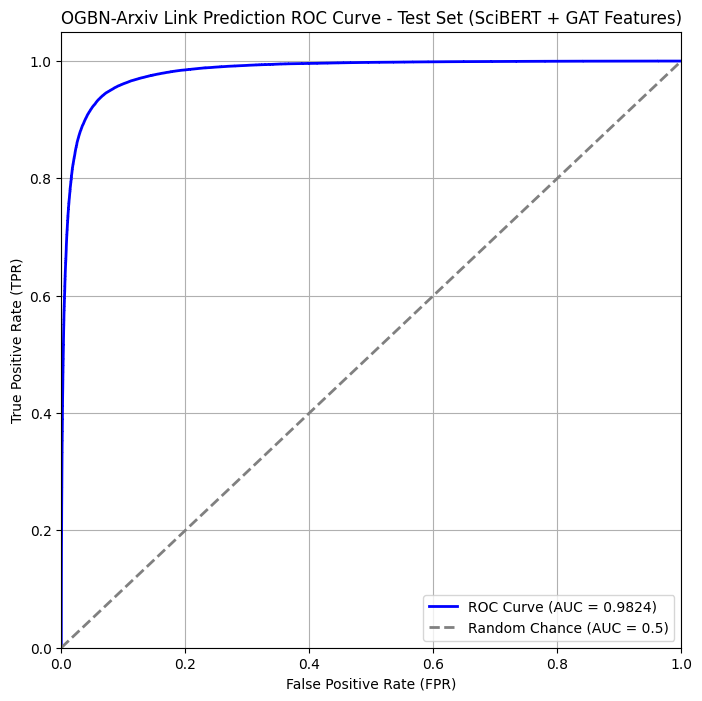

In [15]:
# block 10: Visualize ROC Curve for Link Predictor (OGBN-Arxiv)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

print("\n--- [Link Prediction OGBN-Arxiv] Visualizing Test Set ROC Curve ---")

# 1. 确保模型处于评估模式
link_predictor_arxiv.eval()

with torch.no_grad():
    # 2. 取测试集正、负样本的 logits
    pos_logits = link_predictor_arxiv(node_embeddings_arxiv, split_data_arxiv.test_pos_edge_index)
    neg_logits = link_predictor_arxiv(node_embeddings_arxiv, split_data_arxiv.test_neg_edge_index)

    # 3. 合并 logits 与标签
    logits = torch.cat([pos_logits, neg_logits])
    probs = logits.sigmoid()
    pos_labels = torch.ones(pos_logits.shape[0])
    neg_labels = torch.zeros(neg_logits.shape[0])
    labels = torch.cat([pos_labels, neg_labels])

    # 4. 转为 numpy
    labels_cpu = labels.cpu().numpy()
    probs_cpu = probs.cpu().numpy()

# 5. 计算 ROC 曲线点
fpr, tpr, thresholds = roc_curve(labels_cpu, probs_cpu)

# 6. 绘图
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC Curve (AUC = {final_test_auc_arxiv:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--',
         label='Random Chance (AUC = 0.5)')

# 7. 添加图例与标签
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('OGBN-Arxiv Link Prediction ROC Curve - Test Set (SciBERT + GAT Features)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [16]:
# Ablation：去掉 GAT 层
# 直接用 SciBERT embedding + MLP 训练 link predictor，
# 对比是否 GAT 在低边条件下还有增益。

# Cross-domain Test
# 把模型在 CS 子集上训练，在 Physics 子集上测试，检验迁移鲁棒性。

In [17]:
# block A1 (Ablation: No GAT, Same Head)
import torch
import torch.nn.functional as F
from ogb.nodeproppred import Evaluator

# === 模型定义：去掉 GAT，仅保留相同的线性分类头 ===
class NoGAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.4):
        super().__init__()
        # 模仿 GAT 的三层 MLP 结构（输入/输出维度一致）
        self.fc1 = torch.nn.Linear(in_dim, hidden_dim * 4)   # 与 heads=4 对齐
        self.fc2 = torch.nn.Linear(hidden_dim * 4, hidden_dim * 4)
        self.fc3 = torch.nn.Linear(hidden_dim * 4, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index=None):  # edge_index 保留接口但不使用
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# === 初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

in_dim = data.num_features      # 768 (SciBERT)
hidden_dim = 128
out_dim = int(data.y.max()) + 1

nogat_model = NoGAT(in_dim, hidden_dim, out_dim, dropout=0.4).to(device)
optimizer = torch.optim.Adam(nogat_model.parameters(), lr=0.002, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()
evaluator = Evaluator(name="ogbn-arxiv")

# === 训练 & 验证 ===
def train():
    nogat_model.train()
    optimizer.zero_grad()
    out = nogat_model(data.x)  # 不使用 edge_index
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    nogat_model.eval()
    out = nogat_model(data.x)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[train_idx].unsqueeze(-1),
        'y_pred': y_pred[train_idx]
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[valid_idx].unsqueeze(-1),
        'y_pred': y_pred[valid_idx]
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[test_idx].unsqueeze(-1),
        'y_pred': y_pred[test_idx]
    })['acc']
    return train_acc, valid_acc, test_acc

# === 主训练循环 ===
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    if epoch % 10 == 0:
        print(f"[No-GAT] Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

print(f"\n✅ [No-GAT] Finished. Best Val ACC: {best_val_acc:.4f}, "
      f"Corresponding Test ACC: {best_test_acc:.4f}")


[No-GAT] Epoch 010 | Loss: 2.2298 | Train: 0.4101 | Val: 0.4093 | Test: 0.4119
[No-GAT] Epoch 020 | Loss: 1.7600 | Train: 0.5356 | Val: 0.5426 | Test: 0.5228
[No-GAT] Epoch 030 | Loss: 1.5079 | Train: 0.5945 | Val: 0.6014 | Test: 0.5794
[No-GAT] Epoch 040 | Loss: 1.3966 | Train: 0.6231 | Val: 0.6287 | Test: 0.6122
[No-GAT] Epoch 050 | Loss: 1.3323 | Train: 0.6410 | Val: 0.6451 | Test: 0.6296
[No-GAT] Epoch 060 | Loss: 1.2907 | Train: 0.6523 | Val: 0.6553 | Test: 0.6398
[No-GAT] Epoch 070 | Loss: 1.2614 | Train: 0.6603 | Val: 0.6611 | Test: 0.6485
[No-GAT] Epoch 080 | Loss: 1.2421 | Train: 0.6657 | Val: 0.6654 | Test: 0.6529
[No-GAT] Epoch 090 | Loss: 1.2256 | Train: 0.6700 | Val: 0.6681 | Test: 0.6543
[No-GAT] Epoch 100 | Loss: 1.2160 | Train: 0.6736 | Val: 0.6708 | Test: 0.6582

✅ [No-GAT] Finished. Best Val ACC: 0.6711, Corresponding Test ACC: 0.6582


In [18]:
# block A2 (Ablation: Param-Matched No-GAT)
import torch
import torch.nn.functional as F
from ogb.nodeproppred import Evaluator

print("\n--- [A2] Param-Matched No-GAT Ablation ---")

# === 模型定义：调整 hidden_dim 以匹配 GAT 参数规模 ===
class NoGAT_ParamMatched(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.4):
        super().__init__()
        # 调大 hidden_dim（例如 256 或 384）来匹配 GATConv 的多头参数
        self.fc1 = torch.nn.Linear(in_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index=None):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# === 初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

in_dim = data.num_features      # 768 (SciBERT)
# 🚀 调大 hidden_dim：控制实验匹配 GAT 参数量（大约乘 3）
hidden_dim = 384
out_dim = int(data.y.max()) + 1

nogat_matched_model = NoGAT_ParamMatched(in_dim, hidden_dim, out_dim, dropout=0.4).to(device)
optimizer = torch.optim.Adam(nogat_matched_model.parameters(), lr=0.002, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()
evaluator = Evaluator(name="ogbn-arxiv")

# === 训练 & 验证 ===
def train():
    nogat_matched_model.train()
    optimizer.zero_grad()
    out = nogat_matched_model(data.x)
    loss = criterion(out[train_idx], data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    nogat_matched_model.eval()
    out = nogat_matched_model(data.x)
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[train_idx].unsqueeze(-1),
        'y_pred': y_pred[train_idx]
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[valid_idx].unsqueeze(-1),
        'y_pred': y_pred[valid_idx]
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[test_idx].unsqueeze(-1),
        'y_pred': y_pred[test_idx]
    })['acc']
    return train_acc, valid_acc, test_acc

# === 主训练循环 ===
best_val_acc, best_test_acc = 0, 0
for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc, best_test_acc = val_acc, test_acc
    if epoch % 10 == 0:
        print(f"[A2 No-GAT Param-Matched] Epoch {epoch:03d} | "
              f"Loss: {loss:.4f} | Train: {train_acc:.4f} | "
              f"Val: {val_acc:.4f} | Test: {test_acc:.4f}")

print(f"\n✅ [A2 No-GAT Param-Matched] Finished. "
      f"Best Val ACC: {best_val_acc:.4f}, Test ACC: {best_test_acc:.4f}")



--- [A2] Param-Matched No-GAT Ablation ---
[A2 No-GAT Param-Matched] Epoch 010 | Loss: 2.1448 | Train: 0.4219 | Val: 0.4198 | Test: 0.3899
[A2 No-GAT Param-Matched] Epoch 020 | Loss: 1.6803 | Train: 0.5498 | Val: 0.5537 | Test: 0.5302
[A2 No-GAT Param-Matched] Epoch 030 | Loss: 1.4837 | Train: 0.6030 | Val: 0.6112 | Test: 0.5943
[A2 No-GAT Param-Matched] Epoch 040 | Loss: 1.3880 | Train: 0.6293 | Val: 0.6358 | Test: 0.6209
[A2 No-GAT Param-Matched] Epoch 050 | Loss: 1.3322 | Train: 0.6455 | Val: 0.6499 | Test: 0.6353
[A2 No-GAT Param-Matched] Epoch 060 | Loss: 1.2918 | Train: 0.6542 | Val: 0.6552 | Test: 0.6430
[A2 No-GAT Param-Matched] Epoch 070 | Loss: 1.2631 | Train: 0.6620 | Val: 0.6617 | Test: 0.6475
[A2 No-GAT Param-Matched] Epoch 080 | Loss: 1.2510 | Train: 0.6674 | Val: 0.6677 | Test: 0.6525
[A2 No-GAT Param-Matched] Epoch 090 | Loss: 1.2323 | Train: 0.6706 | Val: 0.6697 | Test: 0.6539
[A2 No-GAT Param-Matched] Epoch 100 | Loss: 1.2255 | Train: 0.6737 | Val: 0.6719 | Test: 0.6

In [19]:
# block A3: Ablation — SciBERT-only Link Prediction (no GAT)
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 0) 依赖检查
assert 'data' in locals(), "data 未定义（需要包含 data.x = SciBERT 向量）"
assert 'split_data_arxiv' in locals(), "请先运行 5.2/5.4（要有 split_data_arxiv 划分）"

# 1) 直接使用 SciBERT 向量（不经过 GAT）
node_embeddings_semantic = data.x.to(device)   # [N, 768]（你的 SciBERT 维度）
embed_dim_sem = node_embeddings_semantic.shape[1]
print(f"[Ablation] Using SciBERT-only embeddings: {tuple(node_embeddings_semantic.shape)}")

# 2) 轻量 MLP 作为链接预测器（与之前一致，但单独命名）
class LinkPredictorSemantic(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, all_node_embeddings, edge_label_index):
        src = all_node_embeddings[edge_label_index[0]]
        dst = all_node_embeddings[edge_label_index[1]]
        h = torch.cat([src, dst], dim=1)
        h = F.relu(self.fc1(h))
        return self.fc2(h).squeeze(-1)

link_predictor_semantic = LinkPredictorSemantic(embed_dim_sem, hidden_dim=64).to(device)
optimizer_semantic = torch.optim.AdamW(link_predictor_semantic.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_semantic = nn.BCEWithLogitsLoss()

# 3) 训练与测试（小批次，避免显存炸）
def train_link_pred_semantic(batch_size=512):
    link_predictor_semantic.train()
    optimizer_semantic.zero_grad()

    pos_edges = split_data_arxiv.train_pos_edge_index
    neg_edges = split_data_arxiv.train_neg_edge_index
    num_pos, num_neg = pos_edges.size(1), neg_edges.size(1)

    # 打乱索引，分批“等量正负采样”
    perm_pos = torch.randperm(num_pos, device=device)
    perm_neg = torch.randperm(num_neg, device=device)

    total_loss, steps = 0.0, 0
    half = max(1, batch_size // 2)
    for start in range(0, num_pos, half):
        end = min(start + half, num_pos)
        p = pos_edges[:, perm_pos[start:end]]
        n = neg_edges[:, perm_neg[start:end]]  # 与正样本等量取

        edges = torch.cat([p, n], dim=1)
        labels = torch.cat([
            torch.ones(p.size(1), device=device),
            torch.zeros(n.size(1), device=device)
        ])

        logits = link_predictor_semantic(node_embeddings_semantic, edges)
        loss = criterion_semantic(logits, labels)

        loss.backward()
        optimizer_semantic.step()
        optimizer_semantic.zero_grad(set_to_none=True)

        total_loss += loss.item() * edges.size(1)
        steps += 1

    return total_loss / (steps * batch_size)

@torch.no_grad()
def test_link_pred_semantic(pos_edge_index, neg_edge_index, batch_size=2048):
    link_predictor_semantic.eval()
    pos_scores, neg_scores = [], []
    P, N = pos_edge_index.size(1), neg_edge_index.size(1)

    for s in range(0, P, batch_size):
        e = pos_edge_index[:, s:min(s+batch_size, P)]
        pos_scores.append(link_predictor_semantic(node_embeddings_semantic, e).sigmoid().cpu())
    for s in range(0, N, batch_size):
        e = neg_edge_index[:, s:min(s+batch_size, N)]
        neg_scores.append(link_predictor_semantic(node_embeddings_semantic, e).sigmoid().cpu())

    pos_scores = torch.cat(pos_scores); neg_scores = torch.cat(neg_scores)
    scores = torch.cat([pos_scores, neg_scores]).numpy()
    labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)]).numpy()
    return roc_auc_score(labels, scores)

# 4) 训练循环
best_val_auc_sem, best_state_sem = 0.0, None
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    loss = train_link_pred_semantic(batch_size=512)
    val_auc = test_link_pred_semantic(split_data_arxiv.val_pos_edge_index, split_data_arxiv.val_neg_edge_index)
    if val_auc > best_val_auc_sem:
        best_val_auc_sem = val_auc
        best_state_sem = {k: v.detach().cpu() for k, v in link_predictor_semantic.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        train_auc = test_link_pred_semantic(split_data_arxiv.train_pos_edge_index, split_data_arxiv.train_neg_edge_index)
        test_auc = test_link_pred_semantic(split_data_arxiv.test_pos_edge_index, split_data_arxiv.test_neg_edge_index)
        print(f"[Ablation][Epoch {epoch:02d}] loss={loss:.4f} | trainAUC={train_auc:.4f} | "
              f"valAUC={val_auc:.4f} | testAUC={test_auc:.4f}")

# 加载最佳验证模型并给出最终测试分数
if best_state_sem is not None:
    link_predictor_semantic.load_state_dict({k: v.to(device) for k, v in best_state_sem.items()})

final_test_auc_semantic = test_link_pred_semantic(
    split_data_arxiv.test_pos_edge_index,
    split_data_arxiv.test_neg_edge_index
)
print(f"\n✅ [Ablation] Final Test AUC (SciBERT-only): {final_test_auc_semantic:.4f}")


[Ablation] Using SciBERT-only embeddings: (169343, 768)
[Ablation][Epoch 01] loss=0.5338 | trainAUC=0.8688 | valAUC=0.8655 | testAUC=0.8654
[Ablation][Epoch 05] loss=0.3328 | trainAUC=0.9339 | valAUC=0.9288 | testAUC=0.9277
[Ablation][Epoch 10] loss=0.2816 | trainAUC=0.9538 | valAUC=0.9454 | testAUC=0.9442

✅ [Ablation] Final Test AUC (SciBERT-only): 0.9442
